In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
plt.rcParams["font.size"] = 8
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

2024-04-19 07:53:20.352979: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 07:53:20.353078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 07:53:20.474003: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir = Path('/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset')
data_dir

PosixPath('/kaggle/input/parkinsons-brain-mri-dataset/parkinsons_dataset')

In [3]:
df = pd.DataFrame({'path': list(data_dir.glob('*/*.png'))})
df['img_id'] = df['path'].map(lambda x: x.stem)
df['disease'] = df['path'].map(lambda x: x.parent.stem)
print(df.shape, 'images loaded')
df.head()

(831, 3) images loaded


,path,img_id,disease
0,/kaggle/input/parkinsons-brain-mri-dataset/par...,mIP_Images(SW)_027,normal
1,/kaggle/input/parkinsons-brain-mri-dataset/par...,Pha_Images_059,normal
2,/kaggle/input/parkinsons-brain-mri-dataset/par...,t1_fl3d_sag_p4_iso_1.0_002,normal
3,/kaggle/input/parkinsons-brain-mri-dataset/par...,ep2d_diff_3scan_trace_p2_TRACEW_DFC_010,normal
4,/kaggle/input/parkinsons-brain-mri-dataset/par...,t2_tirm_tra_dark-fluid_007,normal


In [4]:
df['path'] = df['path'].apply(lambda x: Path(x))

def extract_prefix(file_path):
    prefix = file_path.stem.rsplit('_', 1)[0]
    return prefix

df['label'] = df['path'].apply(extract_prefix)
df

,path,img_id,disease,label
0,/kaggle/input/parkinsons-brain-mri-dataset/par...,mIP_Images(SW)_027,normal,mIP_Images(SW)
1,/kaggle/input/parkinsons-brain-mri-dataset/par...,Pha_Images_059,normal,Pha_Images
2,/kaggle/input/parkinsons-brain-mri-dataset/par...,t1_fl3d_sag_p4_iso_1.0_002,normal,t1_fl3d_sag_p4_iso_1.0
3,/kaggle/input/parkinsons-brain-mri-dataset/par...,ep2d_diff_3scan_trace_p2_TRACEW_DFC_010,normal,ep2d_diff_3scan_trace_p2_TRACEW_DFC
4,/kaggle/input/parkinsons-brain-mri-dataset/par...,t2_tirm_tra_dark-fluid_007,normal,t2_tirm_tra_dark-fluid
...,...,...,...,...
826,/kaggle/input/parkinsons-brain-mri-dataset/par...,sDW_SSh_031,parkinson,sDW_SSh
827,/kaggle/input/parkinsons-brain-mri-dataset/par...,DUAL_TSE_028,parkinson,DUAL_TSE
828,/kaggle/input/parkinsons-brain-mri-dataset/par...,T1W_FFE_002,parkinson,T1W_FFE
829,/kaggle/input/parkinsons-brain-mri-dataset/par...,sDW_SSh_044,parkinson,sDW_SSh


In [5]:
df['label'].value_counts()

label
t1_fl3d_sag_p4_iso_1.0                 176
Pha_Images                              72
Mag_Images                              72
SWI_Images                              72
mIP_Images(SW)                          65
ep2d_diff_3scan_trace_p2_TRACEW_DFC     60
Reg_-_sDW_SSh_SENSE                     44
sDW_SSh                                 44
DUAL_TSE                                44
t2_tirm_tra_dark-fluid                  30
t2_tse_tra                              30
ep2d_diff_3scan_trace_p2_ADC_DFC        30
T2W_FLAIR                               22
T1W_FFE                                 22
dReg_-_sDW_SSh_SENSE                    22
T2W_TSE                                 18
Survey_SHC                               5
localizer                                3
Name: count, dtype: int64

In [6]:
df.nunique()

path       831
img_id     831
disease      2
label       18
dtype: int64

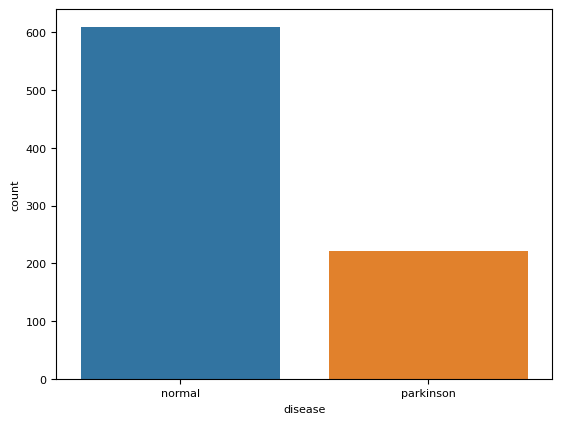

In [7]:
sns.countplot(df, x='disease')
plt.show()

## TRAIN TEST SPLIT

In [8]:
from sklearn.model_selection import train_test_split

X = df['path']
y = df['disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(664,) (664,)
(167,) (167,)


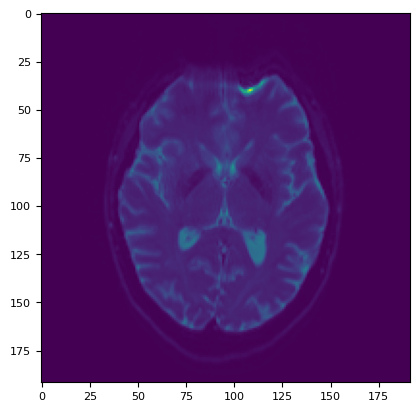

(192, 192)

In [10]:
image = plt.imread(X_train.iloc[1])
plt.imshow(image)
plt.show()

image.shape

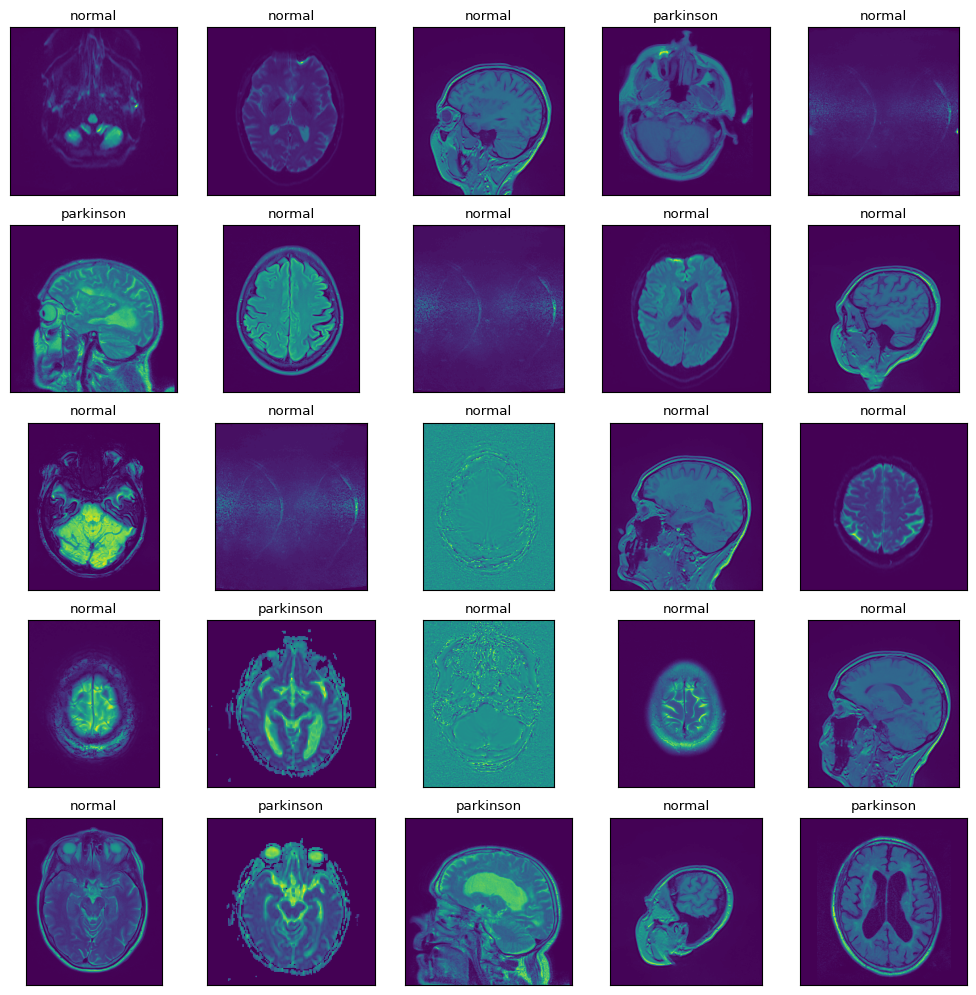

In [11]:
fig, axes = plt.subplots(nrows=5,
                        ncols=5,
                        figsize=(10,10),
                        subplot_kw={"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(X_train.iloc[i]))
    ax.set_title(y_train.iloc[i])
plt.tight_layout()
plt.show()

## TrainDATA

In [12]:
trainData = pd.DataFrame({'path':X_train, 'disease':y_train})
trainData.loc[:, 'path'] = trainData['path'].astype(str)

# train_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
# 
train_generator = train_datagen.flow_from_dataframe(
    dataframe=trainData,
    x_col='path',         
    y_col='disease',      
    target_size=(224, 224), 
    batch_size=32,        
    class_mode='binary'
)

Found 664 validated image filenames belonging to 2 classes.


## TestDATA

In [13]:
testData = pd.DataFrame({'path':X_test, 'disease':y_test})
testData.loc[:, 'path'] = testData['path'].astype(str)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testData,
    x_col='path',         
    y_col='disease',      
    target_size=(224, 224), 
    batch_size=32,        
    class_mode='binary'
)

Found 167 validated image filenames belonging to 2 classes.


# MODEL TRAINING

In [14]:
def loss_history_plot(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [15]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import Model, Sequential

from tensorflow.keras.optimizers import Adam

In [16]:
def train_model(base_model):
    for layer in base_model.layers[:-5]:
            layer.trainable = False
    
    top_model = base_model.output
    top_model = Flatten(name="flatten")(top_model)
#     top_model = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(top_model)
    top_model = Dropout(0.5)(top_model)
    output_layer = Dense(1, activation='sigmoid')(top_model)
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    
#     new_learning_rate = 0.0001 
#     custom_optimizer = Adam(learning_rate=new_learning_rate)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    
    history = model.fit(train_generator, epochs=25, validation_data=test_generator, batch_size = 32)
    
    return model, history

# VGG 16

In [17]:
from keras.applications import VGG16
from tensorflow.keras import regularizers

In [18]:
VGG = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 3s 0us/step


In [19]:
model, history = train_model(VGG)

Epoch 1/25


I0000 00:00:1713513229.010600      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 [==============================] - 25s 741ms/step - loss: 0.8558 - accuracy: 0.7093 - val_loss: 648.1703 - val_accuracy: 0.6707
Epoch 2/25
21/21 [==============================] - 8s 389ms/step - loss: 0.6500 - accuracy: 0.7229 - val_loss: 414.4839 - val_accuracy: 0.7006
Epoch 3/25
21/21 [==============================] - 8s 401ms/step - loss: 0.6523 - accuracy: 0.6913 - val_loss: 72.4923 - val_accuracy: 0.6886
Epoch 4/25
21/21 [==============================] - 8s 383ms/step - loss: 0.6081 - accuracy: 0.7410 - val_loss: 77.5283 - val_accuracy: 0.6647
Epoch 5/25
21/21 [==============================] - 8s 384ms/step - loss: 0.5130 - accuracy: 0.7636 - val_loss: 1959.5471 - val_accuracy: 0.8683
Epoch 6/25
21/21 [==============================] - 8s 383ms/step - loss: 0.4055 - accuracy: 0.8133 - val_loss: 1963.3142 - val_accuracy: 0.8922
Epoch 7/25
21/21 [==============================] - 8s 393ms/step - loss: 0.3119 - accuracy: 0.8690 - val_loss: 987.2825 - val_accuracy: 0.9281
Ep

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
predictions = model.predict(test_generator)
predictions = [1 if x>0.5 else 0 for x in predictions]
true_labels = test_generator.classes
confusion_mtx = confusion_matrix(true_labels, predictions) 
confusion_mtx

6/6 [==============================] - 1s 80ms/step


array([[96, 16],
       [49,  6]])

In [22]:
accuracy = accuracy_score(true_labels, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.61


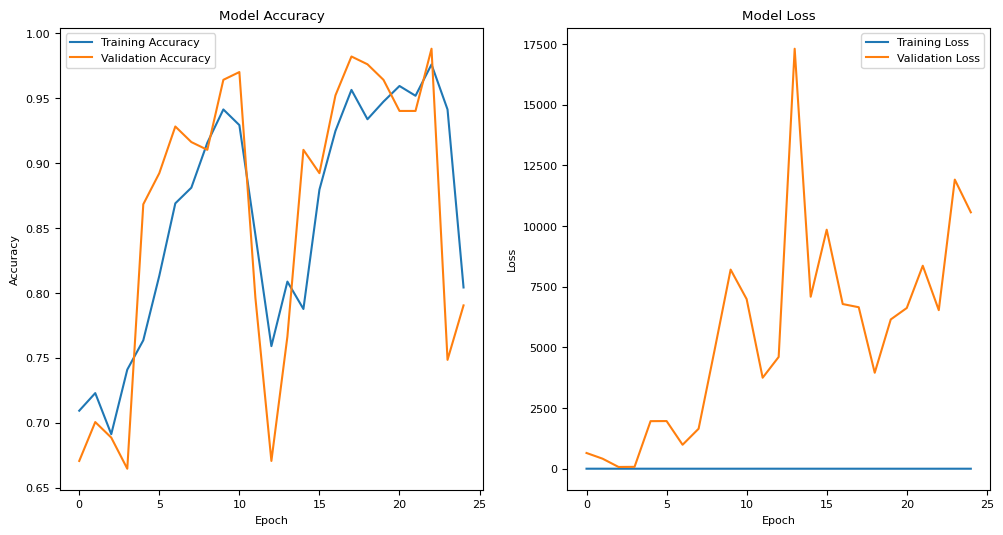

In [23]:
loss_history_plot(history)

# RESNET50

In [24]:
from keras.applications import ResNet50

In [25]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 [==============================] - 4s 0us/step


In [26]:
model, history = train_model(resnet)

Epoch 1/25
21/21 [==============================] - 15s 443ms/step - loss: 1.6643 - accuracy: 0.6672 - val_loss: 3.8481 - val_accuracy: 0.6766
Epoch 2/25
21/21 [==============================] - 8s 386ms/step - loss: 0.7279 - accuracy: 0.7319 - val_loss: 7.5587 - val_accuracy: 0.6707
Epoch 3/25
21/21 [==============================] - 8s 393ms/step - loss: 0.4810 - accuracy: 0.8042 - val_loss: 4.6023 - val_accuracy: 0.6766
Epoch 4/25
21/21 [==============================] - 8s 380ms/step - loss: 0.5864 - accuracy: 0.7666 - val_loss: 3.5494 - val_accuracy: 0.6886
Epoch 5/25
21/21 [==============================] - 8s 379ms/step - loss: 0.5262 - accuracy: 0.7952 - val_loss: 3.2451 - val_accuracy: 0.6826
Epoch 6/25
21/21 [==============================] - 8s 383ms/step - loss: 0.4750 - accuracy: 0.7907 - val_loss: 2.7005 - val_accuracy: 0.6946
Epoch 7/25
21/21 [==============================] - 8s 386ms/step - loss: 0.6218 - accuracy: 0.7696 - val_loss: 1.4784 - val_accuracy: 0.7365
Epoch

In [27]:
predictions = model.predict(test_generator)
predictions = [1 if x>0.5 else 0 for x in predictions]
true_labels = test_generator.classes

confusion_mtx = confusion_matrix(true_labels, predictions) 
confusion_mtx

6/6 [==============================] - 1s 84ms/step


array([[106,   6],
       [ 55,   0]])

In [28]:
accuracy = accuracy_score(true_labels, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.63


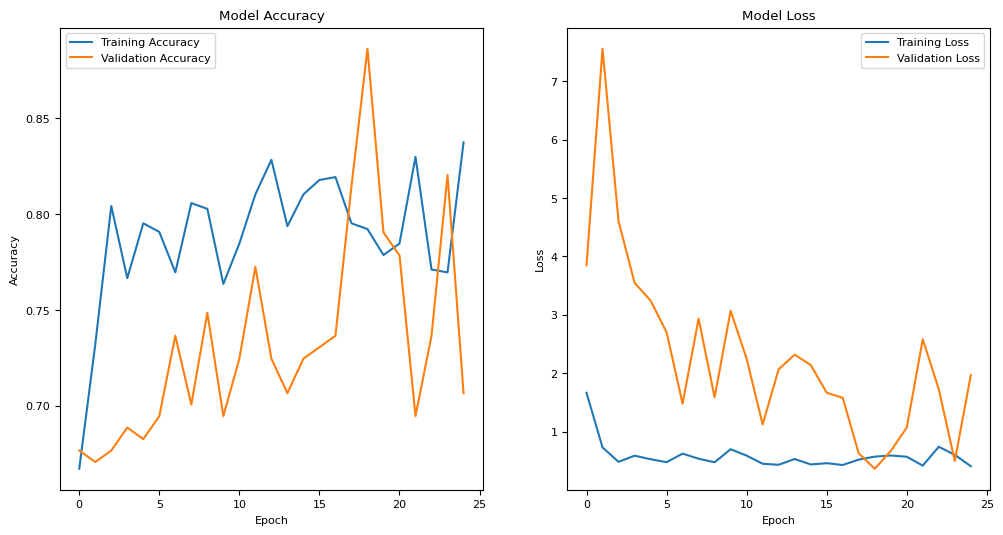

In [29]:
loss_history_plot(history)

# InceptionV3

In [30]:
from keras.applications import InceptionV3

In [31]:
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 4s 0us/step


In [32]:
model, history = train_model(inception)

Epoch 1/25
21/21 [==============================] - 18s 541ms/step - loss: 1.7843 - accuracy: 0.7033 - val_loss: 0.9360 - val_accuracy: 0.7904
Epoch 2/25
21/21 [==============================] - 8s 387ms/step - loss: 0.6471 - accuracy: 0.8419 - val_loss: 0.3761 - val_accuracy: 0.8982
Epoch 3/25
21/21 [==============================] - 8s 384ms/step - loss: 0.3388 - accuracy: 0.9081 - val_loss: 0.1404 - val_accuracy: 0.9401
Epoch 4/25
21/21 [==============================] - 8s 377ms/step - loss: 0.3297 - accuracy: 0.9036 - val_loss: 0.1386 - val_accuracy: 0.9581
Epoch 5/25
21/21 [==============================] - 8s 393ms/step - loss: 0.1718 - accuracy: 0.9473 - val_loss: 0.0900 - val_accuracy: 0.9760
Epoch 6/25
21/21 [==============================] - 8s 376ms/step - loss: 0.1675 - accuracy: 0.9548 - val_loss: 0.0561 - val_accuracy: 0.9820
Epoch 7/25
21/21 [==============================] - 8s 385ms/step - loss: 0.0900 - accuracy: 0.9714 - val_loss: 0.0665 - val_accuracy: 0.9820
Epoch

In [33]:
predictions = model.predict(test_generator)
predictions = [1 if x>0.5 else 0 for x in predictions]
true_labels = test_generator.classes

confusion_mtx = confusion_matrix(true_labels, predictions) 
confusion_mtx

6/6 [==============================] - 2s 81ms/step


array([[68, 44],
       [43, 12]])

In [34]:
accuracy = accuracy_score(true_labels, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.48


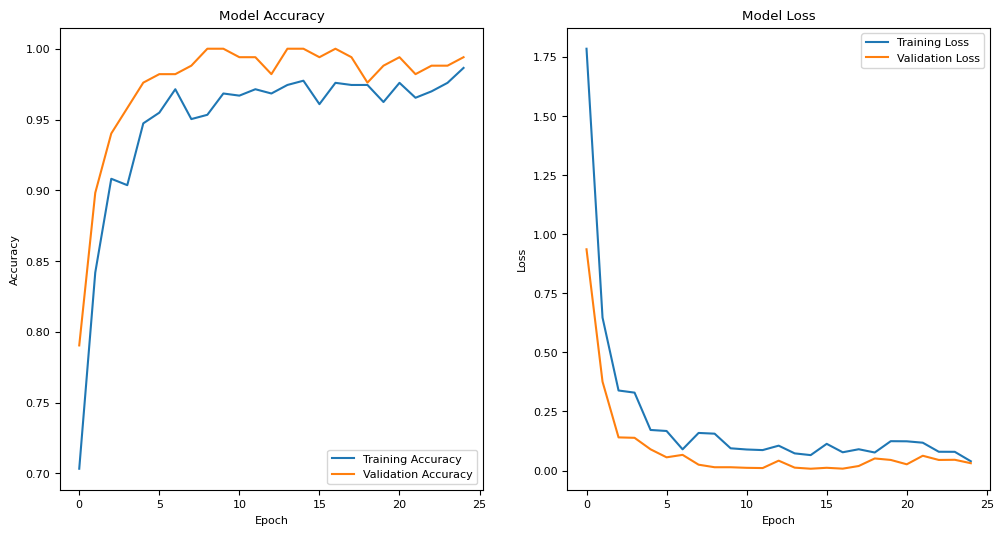

In [35]:
loss_history_plot(history)

# VGG16 Fine Tune

added a new classifier head with Flatten, Dense, Dropout, and Dense

In [36]:


def train_model(base_model):
  """Freezes pre-trained layers and adds a new classifier head for fine-tuning"""
  for layer in base_model.layers[:-5]:
      layer.trainable = False  # Freeze pre-trained layers

  top_model = base_model.output
  top_model = Flatten(name="flatten")(top_model)
  top_model = Dense(256, activation='relu')(top_model)  # New dense layer
  top_model = Dropout(0.5)(top_model)
  output_layer = Dense(1, activation='sigmoid')(top_model)  # Output layer for binary classification

  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(train_generator, epochs=25, validation_data=test_generator, batch_size=32)

  return model, history



In [37]:

# Load pre-trained VGG16 model without the top layers
VGG = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



In [38]:
# Apply fine-tuning
model, history = train_model(VGG)
model.summary()


Epoch 1/25
21/21 [==============================] - 10s 374ms/step - loss: 0.8540 - accuracy: 0.7093 - val_loss: 29588.7402 - val_accuracy: 0.3533
Epoch 2/25
21/21 [==============================] - 8s 394ms/step - loss: 0.7119 - accuracy: 0.7139 - val_loss: 16790.2363 - val_accuracy: 0.6707
Epoch 3/25
21/21 [==============================] - 8s 385ms/step - loss: 0.6373 - accuracy: 0.7485 - val_loss: 28171.2207 - val_accuracy: 0.6707
Epoch 4/25
21/21 [==============================] - 8s 397ms/step - loss: 0.6033 - accuracy: 0.7500 - val_loss: 9640.1621 - val_accuracy: 0.6707
Epoch 5/25
21/21 [==============================] - 8s 384ms/step - loss: 0.5962 - accuracy: 0.7500 - val_loss: 62832.4961 - val_accuracy: 0.6707
Epoch 6/25
21/21 [==============================] - 8s 388ms/step - loss: 0.5821 - accuracy: 0.7500 - val_loss: 22287.1191 - val_accuracy: 0.6707
Epoch 7/25
21/21 [==============================] - 8s 384ms/step - loss: 0.5720 - accuracy: 0.7500 - val_loss: 81477.3828 -

In [39]:
# Evaluate the model
predictions = model.predict(test_generator)
predictions = [1 if x > 0.5 else 0 for x in predictions]
true_labels = test_generator.classes
confusion_mtx = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", confusion_mtx)



6/6 [==============================] - 1s 86ms/step
Confusion Matrix:
 [[111   1]
 [ 54   1]]


In [40]:
# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)



Accuracy: 0.6706586826347305


In [41]:
report = classification_report(true_labels, predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.99      0.80       112
           1       0.50      0.02      0.04        55

    accuracy                           0.67       167
   macro avg       0.59      0.50      0.42       167
weighted avg       0.62      0.67      0.55       167



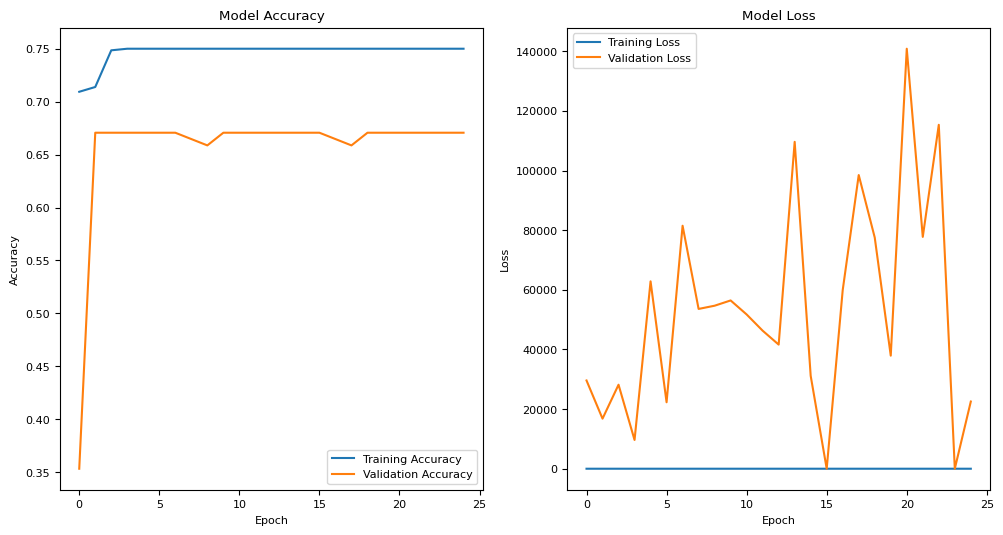

In [42]:
# Plot training history
def loss_history_plot(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

loss_history_plot(history)

# ResNET50 Fine Tune

In [43]:
from keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def train_model(base_model):
  """Freezes pre-trained layers and adds a new classifier head for fine-tuning"""
  for layer in base_model.layers[:-5]:
      layer.trainable = False  # Freeze pre-trained layers

  top_model = base_model.output
  top_model = Flatten(name="flatten")(top_model)
  top_model = Dense(256, activation='relu')(top_model)  # New dense layer
  top_model = Dropout(0.5)(top_model)
  output_layer = Dense(1, activation='sigmoid')(top_model)  # Output layer for binary classification

  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(train_generator, epochs=25, validation_data=test_generator, batch_size=32)

  return model, history





In [44]:
# Load pre-trained ResNet50 model without the top layers
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [45]:
# Apply fine-tuning
model, history = train_model(resnet)
model.summary()


Epoch 1/25
21/21 [==============================] - 13s 420ms/step - loss: 3.2316 - accuracy: 0.6657 - val_loss: 1.5145 - val_accuracy: 0.6707
Epoch 2/25
21/21 [==============================] - 8s 384ms/step - loss: 0.5196 - accuracy: 0.7515 - val_loss: 3.5728 - val_accuracy: 0.6707
Epoch 3/25
21/21 [==============================] - 8s 378ms/step - loss: 0.5298 - accuracy: 0.7500 - val_loss: 3.5915 - val_accuracy: 0.6707
Epoch 4/25
21/21 [==============================] - 8s 390ms/step - loss: 0.4856 - accuracy: 0.7500 - val_loss: 4.2653 - val_accuracy: 0.6707
Epoch 5/25
21/21 [==============================] - 8s 389ms/step - loss: 0.4794 - accuracy: 0.7500 - val_loss: 2.8179 - val_accuracy: 0.6707
Epoch 6/25
21/21 [==============================] - 8s 387ms/step - loss: 0.4841 - accuracy: 0.7500 - val_loss: 2.5079 - val_accuracy: 0.6707
Epoch 7/25
21/21 [==============================] - 8s 381ms/step - loss: 0.4674 - accuracy: 0.7560 - val_loss: 2.0433 - val_accuracy: 0.6707
Epoch

In [46]:
# Evaluate the model
predictions = model.predict(test_generator)
predictions = [1 if x > 0.5 else 0 for x in predictions]
true_labels = test_generator.classes
confusion_mtx = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", confusion_mtx)


6/6 [==============================] - 1s 80ms/step
Confusion Matrix:
 [[112   0]
 [ 55   0]]


In [47]:
# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)

report = classification_report(true_labels, predictions)
print("Classification Report:\n", report)


Accuracy: 0.6706586826347305
Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80       112
           1       0.00      0.00      0.00        55

    accuracy                           0.67       167
   macro avg       0.34      0.50      0.40       167
weighted avg       0.45      0.67      0.54       167



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


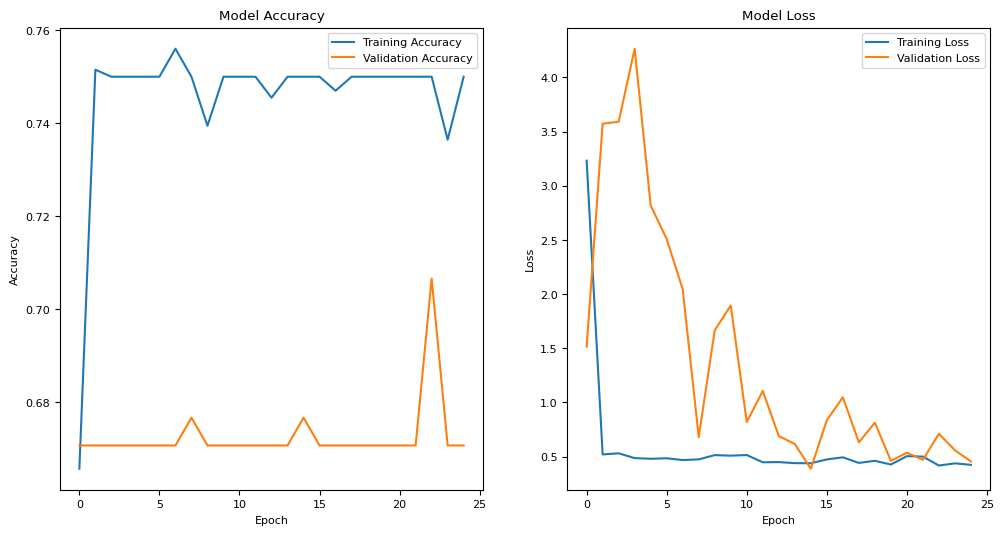

In [48]:
# Plot training history
def loss_history_plot(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

loss_history_plot(history)

# Inception Net fine tune

In [49]:
from keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

In [50]:
def train_model(base_model):
  """Freezes pre-trained layers and adds a new classifier head for fine-tuning"""
  for layer in base_model.layers[:-5]:
      layer.trainable = False  # Freeze pre-trained layers

  top_model = base_model.output
  top_model = Flatten(name="flatten")(top_model)
  top_model = Dense(256, activation='relu')(top_model)  # New dense layer
  top_model = Dropout(0.5)(top_model)
  output_layer = Dense(1, activation='sigmoid')(top_model)  # Output layer for binary classification

  model = Model(inputs=base_model.input, outputs=output_layer)

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  history = model.fit(train_generator, epochs=25, validation_data=test_generator, batch_size=32)

  return model, history


In [51]:
# Load pre-trained InceptionV3 model without the top layers
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [52]:
# Apply fine-tuning
model, history = train_model(inception)
model.summary()

Epoch 1/25
21/21 [==============================] - 14s 434ms/step - loss: 5.3939 - accuracy: 0.7410 - val_loss: 1.6162 - val_accuracy: 0.8383
Epoch 2/25
21/21 [==============================] - 8s 380ms/step - loss: 1.5633 - accuracy: 0.8569 - val_loss: 0.4677 - val_accuracy: 0.9102
Epoch 3/25
21/21 [==============================] - 8s 385ms/step - loss: 0.5200 - accuracy: 0.8810 - val_loss: 0.1206 - val_accuracy: 0.9401
Epoch 4/25
21/21 [==============================] - 8s 396ms/step - loss: 0.2622 - accuracy: 0.9006 - val_loss: 0.1024 - val_accuracy: 0.9641
Epoch 5/25
21/21 [==============================] - 8s 380ms/step - loss: 0.2010 - accuracy: 0.9232 - val_loss: 0.0854 - val_accuracy: 0.9701
Epoch 6/25
21/21 [==============================] - 8s 376ms/step - loss: 0.1977 - accuracy: 0.9262 - val_loss: 0.0374 - val_accuracy: 0.9880
Epoch 7/25
21/21 [==============================] - 8s 380ms/step - loss: 0.1546 - accuracy: 0.9367 - val_loss: 0.0845 - val_accuracy: 0.9641
Epoch

In [53]:
# Evaluate the model
predictions = model.predict(test_generator)
predictions = [1 if x > 0.5 else 0 for x in predictions]
true_labels = test_generator.classes
confusion_mtx = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", confusion_mtx)

6/6 [==============================] - 2s 79ms/step
Confusion Matrix:
 [[79 33]
 [35 20]]


In [54]:
# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
print("Accuracy:", accuracy)

report = classification_report(true_labels, predictions)
print("Classification Report:\n", report)

Accuracy: 0.592814371257485
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.71      0.70       112
           1       0.38      0.36      0.37        55

    accuracy                           0.59       167
   macro avg       0.54      0.53      0.53       167
weighted avg       0.59      0.59      0.59       167



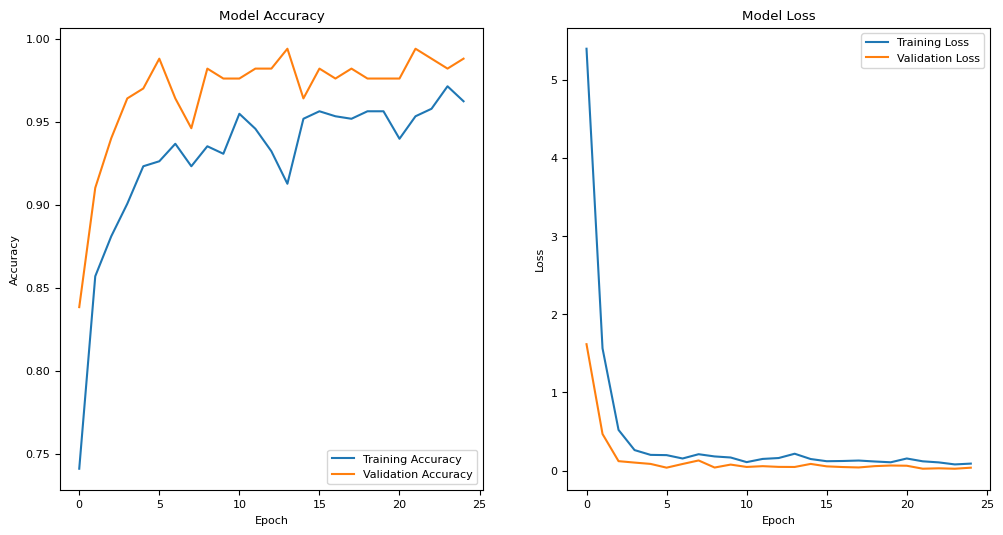

In [55]:
# Plot training history
def loss_history_plot(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

loss_history_plot(history)